# **Project Description:Customer Feedback Sentiment Analysis & Prediction**
 
# **Data Description**:

- A sentiment analysis job about the customer feedback
- Feedback talking about different IT Services, Products, Line of Offerings, Infrastructure etc.

# **Dataset**:

- Contains two columns "review" & "label"
    - review : Customer Feedback about the Product and the Service
    - label : '1' for Negative and '0' for Positive

# **Objective**:

- To classify the sentiment of customer reviews into the positive or negative, with negative sentiments being in focus

# **Steps Applied**:
- Text based EDA
- Basic understanding of text pre-processing.
- What to do after text pre-processing:
    - Bag of words
    - Tf-idf
- Build the classification model.
    - Traditional Supervised Approach

- Tune & Evaluate the Model performance.

## IMPORT ALL THE DEPENDENCIES ACCORDINGLY

In [145]:
import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

# NLP Related Dependencies
from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.
import matplotlib.pyplot as plt                         
import seaborn as sns
from collections import Counter


# Feature Engineering related Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer   
from sklearn.feature_extraction.text import TfidfTransformer

# ML Algorithms that are being experimented
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

# Evaluation Libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import classification_report


# Model Tuning Libraries
from sklearn import metrics
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline


# Logging all the Actions.
import logging                                           
logging.basicConfig(
    filename = "sentiment_analyzer_ml.log",
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anchitsaxena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anchitsaxena/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anchitsaxena/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### DATA LOADING AND ANALYSIS

In [146]:
def read_analyze_data(datafile):
    """
    Read the Data File and Log the Dimension
    Count and Drop Null Values
    
    datafile : Source Data File
    data : Returns non-null df
    """
    data = pd.read_csv(datafile)
    logging.info(str(data.shape))
    logging.info(str(data.isnull().sum(axis=0)))
    data.dropna(inplace=True)
    print(data.shape)
    print(data.isnull().sum(axis=0))
    return data

In [147]:
data = read_analyze_data('review_data.csv')

(3824, 2)
review    0
label     0
dtype: int64


In [148]:
data_copy = data.copy()

## PLOT LABEL BAR PLOT, WORD TAG CLOUD

### GET PERC BARPLOT BASED ON DISTRIBUTION

In [149]:
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [150]:
data.head(10)

,review,label
0,"After 6 years of faithful service, my hard dri...",0
1,So far so good - this is a comprehensive and p...,0
2,This has been a great and easy software to use...,0
3,This router is great. The setup and installati...,0
4,Overview\n\nThis is a great array for someone ...,0
5,"This ""Microsoft Office Home and Student 2010"" ...",0
6,"To be complete, I needed this",0
7,First time user of the product after a decade+...,0
8,Been using this excellent product for years--d...,0
9,Having used Peter Nortons products since their...,0


### **Distribution of sentiments across all the tweets**

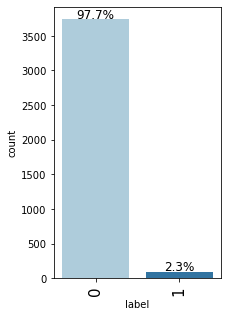

In [151]:
labeled_barplot(data, "label", perc=True)

- **Majority of the tweets are Positive (97.7),followed by negative tweets (2.3%).**
- **This clearly indicates a huge Class Imbalance with majority of samples belonging to "Positive" reviews 

## WORD-DISTRIBUTION PLOT ACROSS NEGATIVE AND POSITIVE FEEDBACK

In [152]:
def plot_hist_pos_neg_feedback(data):
    #Number of words in a tweet
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    pos_len = data[data['label']==0]['review'].str.split().map(lambda x: len(x))
    ax1.hist(pos_len, color='black')
    ax1.set_title('Positive Customer Feedback')
    neg_len = data[data['label']==1]['review'].str.split().map(lambda x: len(x))
    ax2.hist(neg_len,color='purple')
    ax2.set_title('Negative Customer Feedback')
    fig.suptitle('Words in the Feedback')

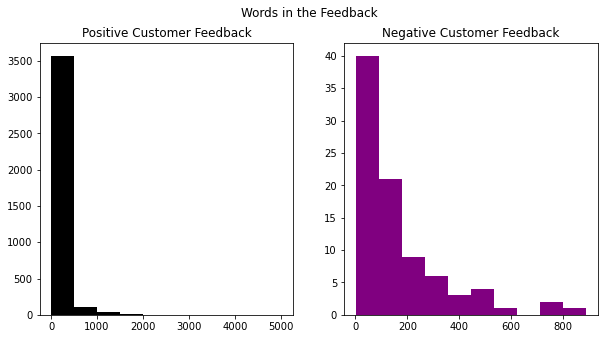

In [153]:
plot_hist_pos_neg_feedback(data)

**OBSERVATIONS**
- Positive Feedbacks are usually around 500 words
- Negative Feedbacks are usually 50-100 words long 

## **Word Cloud Formation**

### **Negative Comments (Without Data Processing)**

In [154]:
from wordcloud import WordCloud,STOPWORDS

In [155]:
def get_cleansed_terms(data, label):
    """
    Get Negative Reviews and check for any HTML Meta Tag
    
    data : Actual df containing Review Data
    
    cleaned_word : Appended Text Blob containing all the neg reviews
    """
    negative_reviews=data[data['label']==label]
    words = ' '.join(data['review'])
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
    return cleaned_word

In [156]:
cleaned_word_neg = get_cleansed_terms(data, 1)

In [157]:
def set_wordcloud_config(bg, width, height, cleaned_word):
    """
    Set the width, height and Background of WordCloud
    
    bg : Background color
    width : Width size
    height : Height size
    """
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color= bg,
                      width=width,
                      height=height
                     ).generate(cleaned_word)
    return wordcloud

In [158]:
wordcloud_neg = set_wordcloud_config('black', 1000, 500, cleaned_word_neg)

In [159]:
def plot_wordcloud(wordcloud):
    plt.figure(1,figsize=(12, 12))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

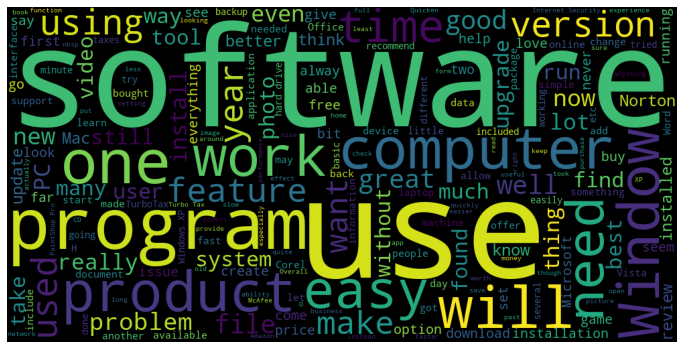

In [160]:
plot_wordcloud(wordcloud_neg)

### Observation
- Problem, Taxes, Slow, Issue, Never looks like few Negative terms.

In [161]:
cleaned_word_pos = get_cleansed_terms(data, 0)

In [162]:
wordcloud_pos = set_wordcloud_config('black', 1000, 500, cleaned_word_pos)

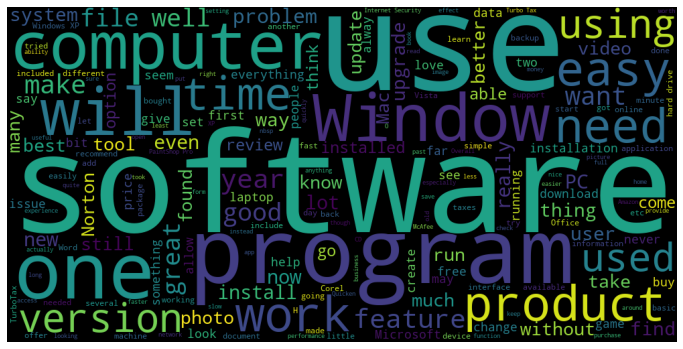

In [163]:
plot_wordcloud(wordcloud_pos)

### Observation
- Best, Better, Easy, Great, Simple looks like few Negative terms.

## Data Pre-processing:

- Remove html tags.
- Replace contractions in string. (e.g. replace I'm --> I am) and so on.\
- Remove numbers.
- Tokenization
- To remove Stopwords.
- Lemmatized data
- We have used NLTK library to tokenize words , remove stopwords and lemmatize the remaining words. 

In [164]:
def strip_html(text):
    """
    Remove HTML Tags, if any
    """
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


In [165]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

In [166]:
def remove_numbers(text):
    text = re.sub(r'\d+', '', text)
    return text

In [167]:
def tokenize_data(data):
    data['review'] = data.apply(lambda row: nltk.word_tokenize(row['review']), axis=1)
    return data

In [168]:
data['review'] = data['review'].apply(lambda x: strip_html(str(x)))
data['review'] = data['review'].apply(lambda x: replace_contractions(x))
data['review'] = data['review'].apply(lambda x: remove_numbers(x))
data = tokenize_data(data)

In [169]:
def filter_stopwords():
    stopwords_ls = stopwords.words('english')

    customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

    # Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, 
    # so not removing them from original data.

    stopwords_mod = list(set(stopwords_ls) - set(customlist))
    return stopwords_mod

In [170]:
stopwords = filter_stopwords()

In [171]:
lemmatizer = WordNetLemmatizer()

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def lemmatize_list(words):
    new_words = []
    for word in words:
        new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

In [172]:
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

In [173]:
data['review'] = data.apply(lambda row: normalize(row['review']), axis=1)
data.head()

,review,label
0,years faithful service hard drive die weeks ag...,0
1,far good comprehensive powerful application bi...,0
2,great easy software use use program keep ms wi...,0
3,router great setup installation easy try route...,0
4,overview great array someone look expand home ...,0


In [174]:
data_cp = data.copy()

###  Most common words in the positive and negative Feedback

In [179]:
data['review'] = data.apply(lambda row: nltk.word_tokenize(row['review']), axis=1) # Tokenization of data

In [180]:
pos_feedback = data[data['label']==0]
neg_feedback = data[data['label']==1]

In [181]:
def get_word_count(pos_feedback, topN):
    top = Counter([item for sublist in pos_feedback['review'] for item in sublist])
    freq_positive = pd.DataFrame(top.most_common(topN))
    freq_positive.columns = ['Common_words','count']
    return freq_positive
    

In [182]:
def plot_common_words(freq_neg):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x='Common_words', y='count', 
            data=freq_neg, ax=ax)
    plt.title("Most Commmon Words in Negative Sentiment tweets")
    plt.xticks(rotation='vertical')

### GET WORD COUNT FOR POSITIVE FEEDBACKS

In [183]:
freq_pos = get_word_count(pos_feedback, 20)
freq_pos.style.background_gradient(cmap='Greens')

,Common_words,count
0,not,4971
1,use,4718
2,software,2739
3,program,2317
4,work,2069
5,get,1921
6,windows,1816
7,like,1611
8,one,1529
9,need,1464


### Plotting BarPlot for Top 20 Positive Terms 

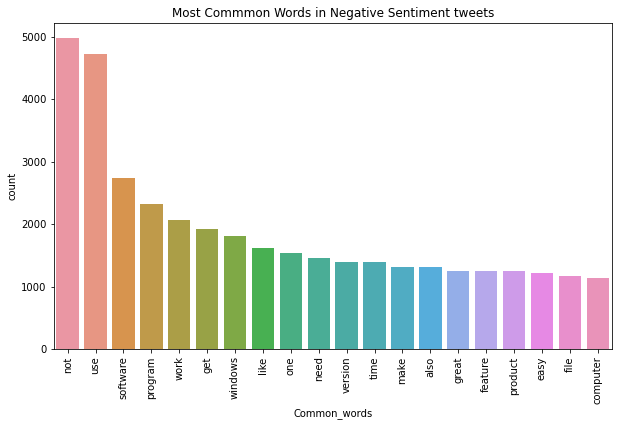

In [184]:
plot_common_words(freq_pos)

### GET WORD COUNT FOR NEGATIVE FEEDBACKS

In [185]:
freq_neg = get_word_count(neg_feedback, 50)
freq_neg.style.background_gradient(cmap='flare')

,Common_words,count
0,not,219
1,use,100
2,software,89
3,windows,74
4,work,62
5,get,53
6,program,53
7,make,52
8,go,48
9,even,47


### Plotting BarPlot for Top 50 Negative Terms

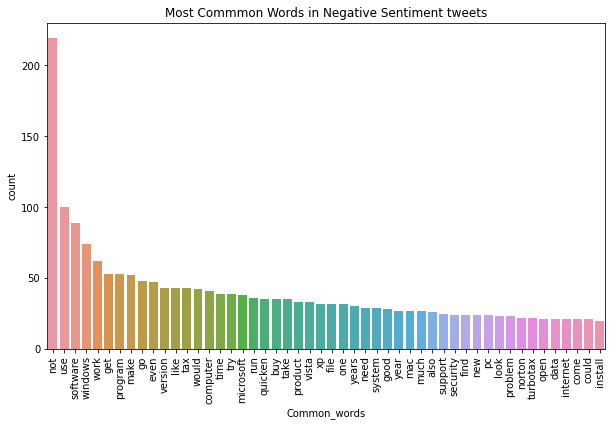

In [186]:
plot_common_words(freq_neg)

## FEATURE ENGINEERING
- Convert Word to Vectors

In [104]:
data = data_cp.copy()

In [105]:
vec_type = {1 : 'CountVectorizer', 2: 'TFIDFVectorizer'}

In [106]:
def get_word_vectorizer(max_features, field_name, vec_type):
    if vec_type == 1:
        # Keep only 5000 features as number of features will increase the processing time.
        vector = CountVectorizer(max_features=max_features)
    else:
        vector = TfidfVectorizer(max_features=max_features)
    data_vector = vector.fit_transform(data[field_name]).toarray()
    return data_vector

    

In [107]:
count_vector = get_word_vectorizer(5000, 'review', 1)

In [108]:
tfidf_vector = get_word_vectorizer(5000, 'review', 2)

### MODELING STARTS HERE

### Model evaluation criterion

### Model can make wrong predictions as:

1. Predicting a Review/Feedback being Negative, but in reality it is Positive. 
2. Predicting a Review/Feednack being Positive, but in actuality it is Negative

### Which case is more important? 
* Both the cases are important as:

* If a positive Feedback is termed as Negative, it's a loss of resource. False Positive

* If a Negative Feedback is termed as Positive, it's a loss of opportunity which in turn will result high Churn Rate. False Negative 



### How to reduce the losses?

* Product would want `F1 Score` to be maximized, greater the F1  score higher are the chances of minimizing False Negatives and False Positives. 

### Starting with Count Vectorizer first 

In [109]:
def split_data(count_vector, data, test_ratio):
    X = count_vector
    y = data.label
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

### Baseline Random Forests

In [110]:
def create_rf_model(n_estimators, X_train, y_train):
    """
    Create a Simple Baseline RF Bagging Classifier
    """
    rf_model = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)
    rf_model = rf_model.fit(X_train, y_train)
    logging.info(np.mean(cross_val_score(rf_model, X_train, y_train, cv=10, scoring = 'f1')))
    return rf_model

In [111]:
X_train, X_test, y_train, y_test = split_data(count_vector, data, 0.3)

In [112]:
rf_model = create_rf_model(10, X_train, y_train)

In [113]:
def get_metrics(rf_model, X_test, y_test):
    y_pred = rf_model.predict(X_test)
    logging.info('F1-Score %s' % f1_score(y_pred, y_test))
    print('F1-Score %s' % f1_score(y_pred, y_test))
    my_tags=['positive', 'negative']
    logging.info(classification_report(y_test, y_pred,target_names=my_tags))
    print(classification_report(y_test, y_pred,target_names=my_tags))

In [114]:
get_metrics(rf_model, X_test, y_test)

F1-Score 0.0
              precision    recall  f1-score   support

    positive       0.98      1.00      0.99      1122
    negative       0.00      0.00      0.00        26

    accuracy                           0.98      1148
   macro avg       0.49      0.50      0.49      1148
weighted avg       0.96      0.98      0.97      1148



In [115]:
def plot_confusion_matrix(model, X_test, y_test):
    result = model.predict(X_test)
    conf_mat = confusion_matrix(y_test, result)

    df_cm = pd.DataFrame(conf_mat, index = [i for i in ['positive', 'negative']],
                  columns = [i for i in ['positive', 'negative']])
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, fmt='g')
    

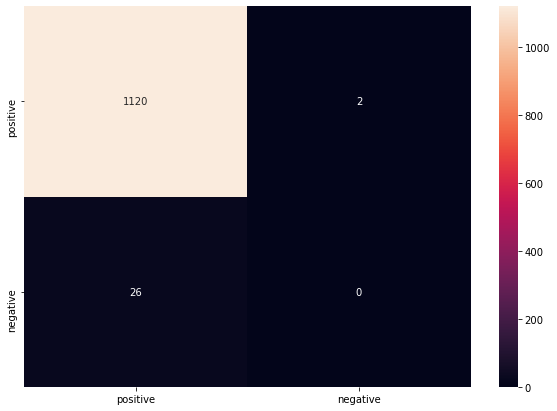

In [116]:
plot_confusion_matrix(rf_model, X_test, y_test)

### OBSERVATIONS:
- "F1" score on Train < 10% which is way less for CV 10
- Clearly all the "Negative Reviews" have been classified as "Positive"

### MODEL TUNING STEPS
- Sampling Techniques
- Hyperparameter Tuning

In [117]:
def apply_oversampling_technique(X_train, y_train, ratio):
    """
    Applying OverSampling Technique with a strategy
    
    ratio : Ratio of Majority:Minority Sample
    """
    sm = SMOTE(
    sampling_strategy=ratio, k_neighbors=5, random_state=1
    )  # Synthetic Minority Over Sampling Technique
    return sm.fit_resample(X_train, y_train)

In [118]:
def apply_undersampling_technique(X_train, y_train, ratio):
    """
    Applying UnderSampling Technique with a strategy
    
    ratio : Ration of Majority:Minority Sample
    """
    return RandomUnderSampler(sampling_strategy=1).fit_resample(X_train, y_train)
    

### Let's start with Oversampling First

In [119]:
X_train_over, y_train_over = apply_oversampling_technique(X_train, y_train, 1)

In [120]:
rf_model_over = create_rf_model(10, X_train_over, y_train_over)

In [121]:
get_metrics(rf_model_over, X_test, y_test)

F1-Score 0.07547169811320754
              precision    recall  f1-score   support

    positive       0.98      0.98      0.98      1122
    negative       0.07      0.08      0.08        26

    accuracy                           0.96      1148
   macro avg       0.53      0.53      0.53      1148
weighted avg       0.96      0.96      0.96      1148



In [122]:
def apply_model_tuning(X_train_over, y_train_over, n_iter, cv):
    """
    Performing Model Tuning 
    
    X_train_over : Independent Training Samples
    y_train_over : Target Training Samples
    """
    rf_tuned = RandomForestClassifier(random_state=1, \
                        oob_score=True, bootstrap=True)

    parameters = {
    "max_depth": list(np.arange(5, 15, 5)),
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [3, 5, 7],
    "n_estimators": np.arange(10, 100, 10),
    }

    # Type of scoring used to compare parameter combinations
    acc_scorer = metrics.make_scorer(metrics.f1_score)

    # Run the grid search
    grid_obj = RandomizedSearchCV(rf_tuned, parameters, scoring=acc_scorer, \
                            cv=cv, n_jobs=-1, n_iter=n_iter)
    grid_obj = grid_obj.fit(X_train_over, y_train_over)

    # Set the clf to the best combination of parameters
    rf_tuned = grid_obj.best_estimator_

    # Fit the best algorithm to the data.
    rf_tuned.fit(X_train_over, y_train_over)
    return rf_tuned
    

In [123]:
rf_tuned = apply_model_tuning(X_train_over, y_train_over, 50, 5)

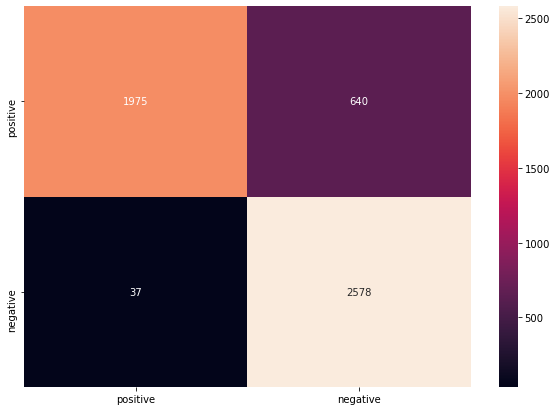

In [124]:
plot_confusion_matrix(rf_tuned, X_train_over, y_train_over)

In [125]:
get_metrics(rf_tuned, X_test, y_test)

F1-Score 0.030864197530864196
              precision    recall  f1-score   support

    positive       0.98      0.74      0.84      1122
    negative       0.02      0.19      0.03        26

    accuracy                           0.73      1148
   macro avg       0.50      0.47      0.44      1148
weighted avg       0.95      0.73      0.82      1148



### KEY-OBSERVATION
- Oversampling with Hyperparameter Tuning doesn't seems to working. F1 for Positive have gone down further.

### Let's check with Undersampling 

In [126]:
X_train_under, y_train_under = apply_undersampling_technique(X_train, y_train, 1)

In [127]:
rf_tuned_under = apply_model_tuning(X_train_over, y_train_over, 50, 5)

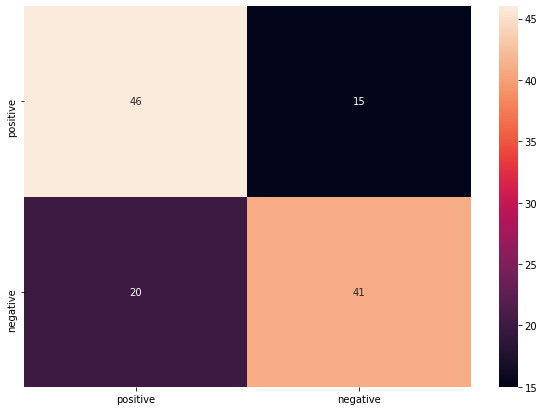

In [128]:
plot_confusion_matrix(rf_tuned_under, X_train_under, y_train_under)

In [129]:
get_metrics(rf_tuned_under, X_test, y_test)

F1-Score 0.024024024024024024
              precision    recall  f1-score   support

    positive       0.97      0.73      0.83      1122
    negative       0.01      0.15      0.02        26

    accuracy                           0.72      1148
   macro avg       0.49      0.44      0.43      1148
weighted avg       0.95      0.72      0.82      1148



# CRITICAL OBSERVATIONS:
- Even after applying Feature Engineering, Hyperparameter Tuning & Sampling F1 score for "Negative" Feedback is low.
- Next step is to try other Traditional approaches like SVM, Logistic Regression to see if it helps.

In [130]:
def evaluate_ml_algo(algo_type):
    """
    Create a sklearn Pipeline
    
    algo_type : ML Algo type
    """
    nb = Pipeline([
               ('clf', algo_type),
              ])
    nb.fit(X_train_over, y_train_over)

    y_pred = nb.predict(X_test)

    logging.info('F1-Score' + str(algo_type) + '%s' % f1_score(y_pred, y_test))
    logging.info(classification_report(y_test, y_pred,target_names=['positive', 'negative']))
    print('F1-Score' + str(algo_type) + '%s' % f1_score(y_pred, y_test))
    print(classification_report(y_test, y_pred,target_names=['positive', 'negative']))

In [131]:
models = {"MNB": MultinomialNB(), "LR" : LogisticRegression(n_jobs=-1, C=1e5), 
             "SGD": SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)}

In [132]:
for model in models:
    evaluate_ml_algo(models[model])

F1-ScoreMultinomialNB()0.05555555555555555
              precision    recall  f1-score   support

    positive       0.98      0.93      0.95      1122
    negative       0.04      0.12      0.06        26

    accuracy                           0.91      1148
   macro avg       0.51      0.52      0.50      1148
weighted avg       0.96      0.91      0.93      1148

F1-ScoreLogisticRegression(C=100000.0, n_jobs=-1)0.14492753623188406
              precision    recall  f1-score   support

    positive       0.98      0.97      0.97      1122
    negative       0.12      0.19      0.14        26

    accuracy                           0.95      1148
   macro avg       0.55      0.58      0.56      1148
weighted avg       0.96      0.95      0.95      1148

F1-ScoreSGDClassifier(alpha=0.001, max_iter=5, random_state=42, tol=None)0.08695652173913043
              precision    recall  f1-score   support

    positive       0.98      0.94      0.96      1122
    negative       0.06      0.1

/Users/anchitsaxena/Downloads/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:550: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/anchitsaxena/Downloads/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:550: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/anchitsaxena/Downloads/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:550: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/anchitsaxena/Downloads/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:550: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  wa

/Users/anchitsaxena/Downloads/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:550: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/anchitsaxena/Downloads/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:550: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/anchitsaxena/Downloads/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:550: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/anchitsaxena/Downloads/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:550: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  wa

/Users/anchitsaxena/Downloads/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:550: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/anchitsaxena/Downloads/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:550: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/anchitsaxena/Downloads/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:550: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/anchitsaxena/Downloads/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:550: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  wa

### FINAL RECOMMENDATIONS:
- Traditional ML Models are Failing 
- Need to explore Transfer Learning route